# 加入技術指標，使用 Prophet 預測台股股價

## 載入相關套件

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from prophet import Prophet
import talib

## 載入資料集

In [2]:
START_DATE = '2020-01-01'
END_DATE = '2024-11-30'
CLOSE_FIELD_NAME = 'Close'
df = yf.download('^TWII', START_DATE, END_DATE)
df.tail(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^TWII,^TWII,^TWII,^TWII,^TWII
Date,,,,,
2024-11-18,22546.539062,22781.769531,22503.689453,22693.960938,3431100
2024-11-19,22848.800781,22906.689453,22578.750000,22614.740234,3689400
2024-11-20,22688.359375,22977.560547,22622.470703,22872.910156,3757700
2024-11-21,22555.660156,22708.570312,22490.279297,22671.660156,3395800
2024-11-22,22904.320312,23019.039062,22799.529297,22799.529297,3505100
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000


## 資料轉換

In [3]:
df.columns = [item[0] for item in df.columns]
df.tail(10)

,Close,High,Low,Open,Volume
Date,,,,,
2024-11-18,22546.539062,22781.769531,22503.689453,22693.960938,3431100
2024-11-19,22848.800781,22906.689453,22578.750000,22614.740234,3689400
2024-11-20,22688.359375,22977.560547,22622.470703,22872.910156,3757700
2024-11-21,22555.660156,22708.570312,22490.279297,22671.660156,3395800
2024-11-22,22904.320312,23019.039062,22799.529297,22799.529297,3505100
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000
2024-11-28,22298.900391,22413.250000,22124.310547,22380.449219,3123400


In [4]:
# 移動平均月線
df['SMA_20'] = talib.SMA(df['Close'].values.reshape(-1), timeperiod=22)
# RSI
df['RSI'] = talib.RSI(df.Close.values.reshape(-1), timeperiod=14)
# MACD
real = talib.DX(df.High.values.reshape(-1), df.Low.values.reshape(-1), 
                df.Close.values.reshape(-1), timeperiod=14)
df['MACD'], df['Signal'], _ = talib.MACD(real, fastperiod=12, slowperiod=26, signalperiod=9)

In [5]:
df['SMA_20'] = df['SMA_20'].shift(1)
df['RSI'] = df['RSI'].shift(1)
df['MACD'] = df['MACD'].shift(1)

In [6]:
df = df.dropna()
df.tail()

,Close,High,Low,Open,Volume,SMA_20,RSI,MACD,Signal
Date,,,,,,,,,
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900,23010.301847,50.359590,-0.797557,-0.954949
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600,22992.738636,51.241401,-1.519150,-1.083578
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000,22969.385920,45.870368,-1.598094,-1.032603
2024-11-28,22298.900391,22413.250000,22124.310547,22380.449219,3123400,22923.310014,40.095804,-0.828704,-0.771854
2024-11-29,22262.500000,22429.859375,22055.380859,22202.279297,2801000,22882.438654,39.536719,0.271144,-0.360556


## 繪圖

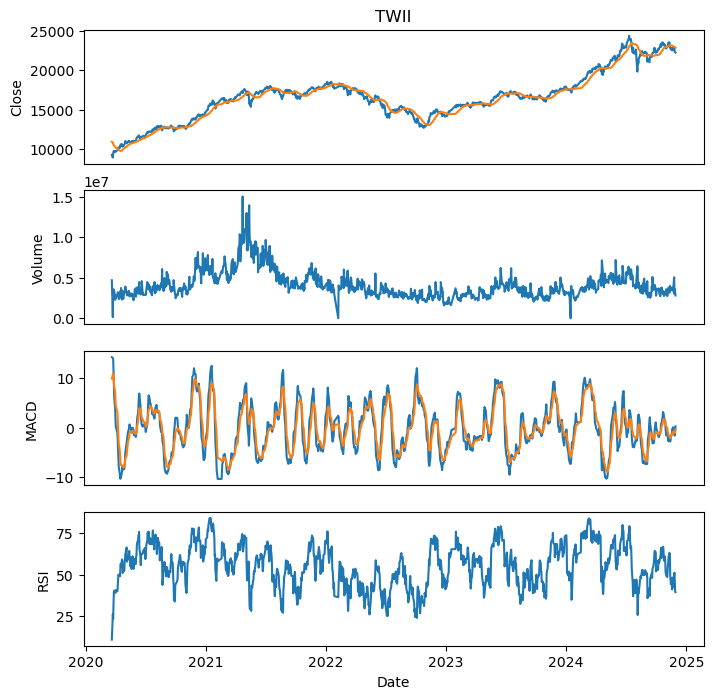

In [7]:
plt.figure(figsize=(8, 8))
plt.subplot(4,1,1)
sns.lineplot(x=df.index, y=CLOSE_FIELD_NAME, data=df)
sns.lineplot(x=df.index, y='SMA_20', data=df)
plt.title('TWII')
plt.xticks([])
plt.xlabel('')
plt.subplot(4,1,2)
sns.lineplot(x=df.index, y='Volume', data=df)
plt.xticks([])
plt.xlabel('')
plt.subplot(4,1,3)
sns.lineplot(x=df.index, y='MACD', data=df)
sns.lineplot(x=df.index, y='Signal', data=df)
plt.xticks([])
plt.xlabel('')
plt.subplot(4,1,4)
sns.lineplot(x=df.index, y='RSI', data=df)
plt.show()

In [8]:
df2 = df.copy()
df2 = df2.reset_index()
dt_range = pd.date_range(start=START_DATE, end=END_DATE).to_frame(name='Date')
df2 = pd.merge(df2, dt_range, on='Date', how="right")
df2.tail(7)

,Date,Close,High,Low,Open,Volume,SMA_20,RSI,MACD,Signal
1789,2024-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1790,2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900.0,23010.301847,50.359590,-0.797557,-0.954949
1791,2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600.0,22992.738636,51.241401,-1.519150,-1.083578
1792,2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000.0,22969.385920,45.870368,-1.598094,-1.032603
1793,2024-11-28,22298.900391,22413.250000,22124.310547,22380.449219,3123400.0,22923.310014,40.095804,-0.828704,-0.771854
1794,2024-11-29,22262.500000,22429.859375,22055.380859,22202.279297,2801000.0,22882.438654,39.536719,0.271144,-0.360556
1795,2024-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df2 = df2.ffill() # 以前一天填補 missing value
df2 = df2.bfill() # 以後一天填補 missing value
df2 = df2.set_index('Date') 
df2

,Close,High,Low,Open,Volume,SMA_20,RSI,MACD,Signal
Date,,,,,,,,,
2020-01-01,9234.089844,9264.419922,8816.860352,8816.860352,4683400.0,10901.401767,10.970396,14.201460,9.871939
2020-01-02,9234.089844,9264.419922,8816.860352,8816.860352,4683400.0,10901.401767,10.970396,14.201460,9.871939
2020-01-03,9234.089844,9264.419922,8816.860352,8816.860352,4683400.0,10901.401767,10.970396,14.201460,9.871939
2020-01-04,9234.089844,9264.419922,8816.860352,8816.860352,4683400.0,10901.401767,10.970396,14.201460,9.871939
2020-01-05,9234.089844,9264.419922,8816.860352,8816.860352,4683400.0,10901.401767,10.970396,14.201460,9.871939
...,...,...,...,...,...,...,...,...,...
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600.0,22992.738636,51.241401,-1.519150,-1.083578
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000.0,22969.385920,45.870368,-1.598094,-1.032603
2024-11-28,22298.900391,22413.250000,22124.310547,22380.449219,3123400.0,22923.310014,40.095804,-0.828704,-0.771854


## 特徵縮放

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df2[['Volume', 'SMA_20', 'RSI', 'MACD']] = scaler.fit_transform(df2[['Volume', 'SMA_20', 'RSI', 'MACD']])
df2.head()

,Close,High,Low,Open,Volume,SMA_20,RSI,MACD,Signal
Date,,,,,,,,,
2020-01-01,9234.089844,9264.419922,8816.860352,8816.860352,0.371183,-1.676484,-2.776447,2.422798,9.871939
2020-01-02,9234.089844,9264.419922,8816.860352,8816.860352,0.371183,-1.676484,-2.776447,2.422798,9.871939
2020-01-03,9234.089844,9264.419922,8816.860352,8816.860352,0.371183,-1.676484,-2.776447,2.422798,9.871939
2020-01-04,9234.089844,9264.419922,8816.860352,8816.860352,0.371183,-1.676484,-2.776447,2.422798,9.871939
2020-01-05,9234.089844,9264.419922,8816.860352,8816.860352,0.371183,-1.676484,-2.776447,2.422798,9.871939


## 資料分割

In [11]:
from sklearn.model_selection import train_test_split

# REGRESSORS = ['Volume', 'SMA_20', 'RSI', 'MACD']
REGRESSORS = ['Volume', 'RSI', 'MACD']
df2 = df[[CLOSE_FIELD_NAME] + REGRESSORS].copy()

# 欄位改名
df2 = df2.reset_index()
df2.columns = ['ds', 'y'] + REGRESSORS

# 資料分割
test_size=60
X_train, X_test = train_test_split(df2, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((1085, 5), (60, 5))

## 模型訓練

In [12]:
m = Prophet()
for i in REGRESSORS:
    m.add_regressor(i)
m.fit(X_train)

09:10:54 - cmdstanpy - INFO - Chain [1] start processing
09:10:54 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
future = m.make_future_dataframe(periods=test_size, freq = 'D')
future[REGRESSORS] = df2[REGRESSORS]
predict = m.predict(future)
predict.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,MACD,MACD_lower,MACD_upper,RSI,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1140,2024-10-25,22864.536935,21610.937381,22511.977847,22627.283292,23146.988879,6.718438,6.718438,6.718438,-170.120542,...,145.262285,145.262285,145.262285,-800.020231,-800.020231,-800.020231,0.0,0.0,0.0,22048.698467
1141,2024-10-26,22880.373809,21113.299746,22010.794883,22631.323304,23168.737476,13.267553,13.267553,13.267553,-142.094844,...,-378.866812,-378.866812,-378.866812,-818.343517,-818.343517,-818.343517,0.0,0.0,0.0,21551.456498
1142,2024-10-27,22896.210684,20952.545012,21857.681925,22638.809007,23193.609043,13.984042,13.984042,13.984042,-312.796843,...,-378.866813,-378.866813,-378.866813,-835.223886,-835.223886,-835.223886,0.0,0.0,0.0,21381.918323
1143,2024-10-28,22912.047558,21265.003086,22192.139690,22650.405833,23220.973476,7.001128,7.001128,7.001128,-496.323864,...,138.896372,138.896372,138.896372,-850.654762,-850.654762,-850.654762,0.0,0.0,0.0,21708.434114
1144,2024-10-29,22927.884432,21237.151331,22183.111907,22656.027670,23245.766310,-2.980996,-2.980996,-2.980996,-514.092681,...,147.267920,147.267920,147.267920,-864.633494,-864.633494,-864.633494,0.0,0.0,0.0,21690.100142


In [14]:
predict.iloc[-test_size]['ds']

Timestamp('2024-08-31 00:00:00')

In [15]:
X_test.iloc[0]['ds']

Timestamp('2024-09-02 00:00:00')

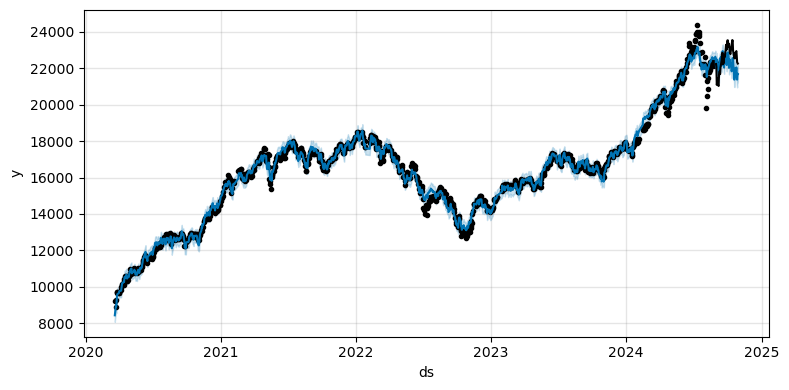

In [16]:
fig1 = m.plot(predict, figsize=(8, 4))
plt.plot(predict.iloc[-test_size:]['ds'], X_test['y'], 'black');

## 效應分解(Decomposition)

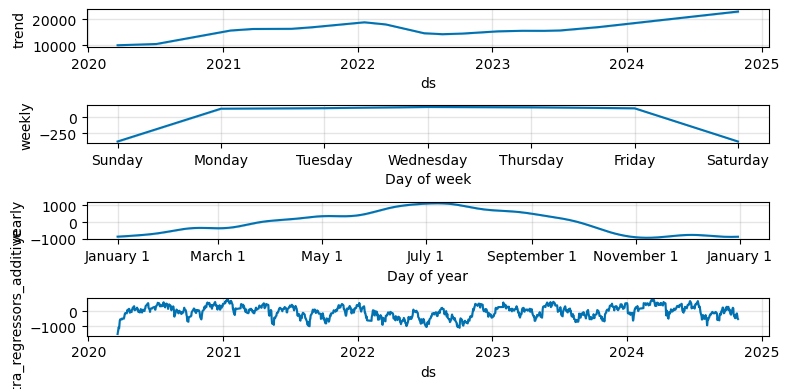

In [17]:
fig2 = m.plot_components(predict, figsize=(8, 4))

## 繪圖：比較實際值與預測值

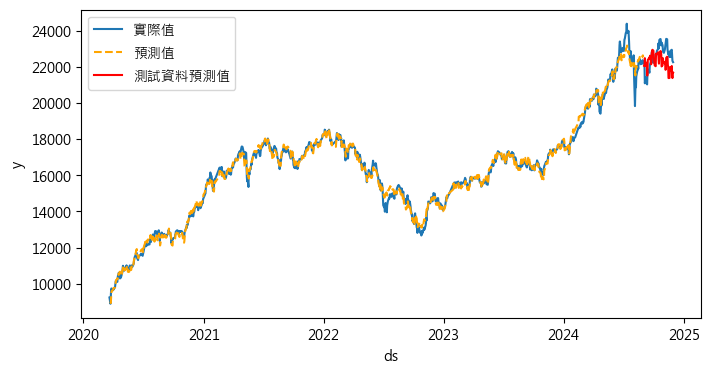

In [18]:
# 修正中文亂碼 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,4))
df2['predict'] = predict['yhat'].values
sns.lineplot(data=df2, x='ds', y='y', label='實際值')
# sns.lineplot(data=df2, x='ds', y='predict', label='預測值')
sns.lineplot(data=df2.iloc[1:-test_size], x='ds', y='predict', 
             color='orange', label='預測值', linestyle='--')
sns.lineplot(data=df2.iloc[-test_size:], x='ds', y='predict', color='red', label='測試資料預測值')
plt.legend();

In [19]:
df2['residual'] = df2['y'] - df2['predict']
print(f'MSE = {(np.sum(df2['residual']**2) / len(df2['residual'])):.2f}')

MSE = 96792.25


## 殘差(residual)繪圖

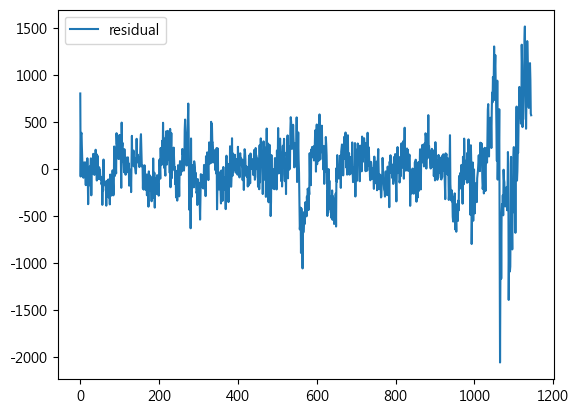

In [20]:
residuals = pd.DataFrame(df2['residual'])
residuals.plot();